In [5]:
# !pip3 install xgboost

<strong>In previous document cleaning and selecting best features is done. Here we shall vectorize those best features and apply machine learning models</strong>

In [6]:
import os
import sys
import pandas as pd
import time
import numpy as np
import seaborn as sns
from gensim.models import  Word2Vec
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from prettytable import PrettyTable

import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,roc_curve,auc,confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import sparse
from scipy.sparse import hstack,vstack
from zipfile import ZipFile
import pickle

import warnings 
warnings.filterwarnings('ignore')

## Reading Data

In [7]:

base_dir = '' # base_dir is give the link of the directory so that if
# directory of data changes anytime we just make changes here and it reflects in whole document
data = pd.read_csv(base_dir+'data/final_data.csv')

In [8]:
data.head()

,keyword,text,target,clean_text,char_count,word_count,stop_word_count,mean_word_length,punctuation_count
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,38.0,7.0,0.0,4.571429,1.0
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,88.0,16.0,6.0,4.500000,2.0
2,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,110.0,18.0,3.0,5.166667,7.0
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,95.0,14.0,2.0,5.857143,3.0
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,59.0,15.0,8.0,3.000000,4.0


<strong>Lets drop text(raw data) column because instead of that we'll be using clean_text column</strong>

In [9]:

final_data = data.drop(['text'],axis=1)
print('Shape of the data:',final_data.shape)
final_data.head(2)

Shape of the data: (7613, 8)


,keyword,target,clean_text,char_count,word_count,stop_word_count,mean_word_length,punctuation_count
0,NaN,1,deed reason earthquak may allah forgiv us,38.0,7.0,0.0,4.571429,1.0
1,NaN,1,forest fire near la rong sask canada,88.0,16.0,6.0,4.500000,2.0


<strong>Converting keyword and clean_text columns to string type(there might be some np.nan values so, get get rid of those nan values we perform this operation)</strong><br>

<strong>Will lot of data effect this?</strong><br>
No because keyword was having only 61 nan values and clean text will have only 3 nan values as we removed timestamp kind of rows in previous document if you can recall them the index numbers of those rows are 3053,7140,7610.

In [10]:
final_data.keyword  =  final_data.keyword.apply(lambda x:str(x))
final_data.clean_text  =  final_data.clean_text.apply(lambda x:str(x))

### Splitting data
Splitting data into 70-30 ratio i.e traing data will have 70% of the data and test data will have 30% of the data

In [65]:
x = final_data.drop(['target'],axis=1)
y = final_data.target

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)


print('Shape of xtrain :',xtrain.shape)
print('Shape of ytrain :',ytrain.shape)
print('---'*10)
print('Shape of xtest :',xtest.shape)
print('Shape of ytest :',ytest.shape)


Shape of xtrain : (5329, 7)
Shape of ytrain : (5329,)
------------------------------
Shape of xtest : (2284, 7)
Shape of ytest : (2284,)


In [66]:
print(pd.DataFrame(ytrain)['target'].value_counts())
print(pd.DataFrame(ytest)['target'].value_counts())

0    3064
1    2265
Name: target, dtype: int64
0    1278
1    1006
Name: target, dtype: int64


In [68]:
print('Train data has {}% of class 1 and {}% of class 0 points'.format(3064/(5329),2265/5329))
print('Test  data has {}% of class 1 and {}% of class 0 points'.format(1278/(2284),1006/2284))


Train data has 0.5749671608181648% of class 1 and 0.42503283918183526% of class 0 points
Test  data has 0.5595446584938704% of class 1 and 0.4404553415061296% of class 0 points


<strong>Above percentage of class in test and train data has almost same percent of both the class in both the data sets(train,test) so lets move forward applying vectorization techniques</strong>

In [69]:
# In future if we want to dump or get files from pickle we'll make use of below functions
def pickleit(file_,name):
    
    with open(base_dir+name,'wb') as f:
        pickle.dump(file_,f)

def load_pickle(name):
    base_path = base_dir+'pickle/'
    with open(base_path+name,'rb') as f:
        return pickle.load(f)        

In [70]:
class Featurize:
    def __init__(self,train,test):
        '''
            Given train and test data  we can perform countvectorization, tfidf vectorization  
            and normalizing the data(for int type of data)
            
            train   : train data
            test    : test  data
            
        '''
        
        self.train = train
        self.test  = test
        
        
        self.countvect          = 0
        self.countvect_train    = 0
        self.countvect_test     = 0

        
        self.tfidfvect          = 0
        self.tfidfvect_train    = 0
        self.tfidfvect_test     = 0

         
        self.normal             = Normalizer()
        self.normal_train       = 0
        self.normal_test        = 0

        
    def CountVect(self,ngram):
            '''
                Gets countvectorization for given train and test data
                
                ngrams  : Used to pass to countvectorizer, represents ngram to use
            '''
        
            self.countvect = CountVectorizer(ngram_range=ngram)
            self.countvect_train = self.countvect.fit_transform(self.train)
            self.countvect_test  = self.countvect.transform(self.test)
            
    def TfidfVect(self,ngram):
        
            '''
                Gets tfidf vectorization for given train and test data
                
                ngrams  : Used to pass to countvectorizer, represents ngram to use
            '''
            
        
            self.tfidfvect = TfidfVectorizer(ngram_range=ngram)
            self.tfidfvect_train = self.tfidfvect.fit_transform(self.train)
            self.tfidfvect_test  = self.tfidfvect.transform(self.test)
            
            
    def Normalvect(self):
            self.normal = Normalizer()
            self.train = self.train.fillna(0)
            self.test  = self.test.fillna(0)
            self.normal_train = sparse.csr_matrix(self.normal.fit_transform(self.train.values.reshape(-1,1)))
            self.normal_test  = sparse.csr_matrix(self.normal.transform(self.test.values.reshape(-1,1)))

    

## Vectorizing/Featurizing

### Keyword

In [137]:
keywords = Featurize(train=xtrain.keyword,test=xtest.keyword)
keywords.CountVect((1,2))
keywords.TfidfVect((1,2))


### Clean_text

In [138]:
clean_text = Featurize(xtrain.clean_text,xtest.clean_text)
clean_text.CountVect((1,2))
clean_text.TfidfVect((1,2))


### All handcrafted columns

In [73]:
char_cout_normal = Featurize(xtrain.char_count,xtest.char_count)
char_cout_normal.Normalvect()
word_count_normal = Featurize(xtrain.word_count ,xtest.word_count)
word_count_normal.Normalvect()
stop_word_count_normal = Featurize(xtrain.stop_word_count ,xtest.stop_word_count)
stop_word_count_normal.Normalvect()
mean_word_length_normal = Featurize(xtrain.mean_word_length ,xtest.mean_word_length)
mean_word_length_normal.Normalvect()
punctuation_count_normal = Featurize(xtrain.punctuation_count ,xtest.punctuation_count)
punctuation_count_normal.Normalvect()


### Applying Models on countvectorization

#### Joining all features

#### Countvectors + handcrafted 

In [139]:
x_countvect_train_all = hstack((keywords.countvect_train,
                        clean_text.countvect_train,
                        char_cout_normal.normal_train,
                        word_count_normal.normal_train,
                        stop_word_count_normal.normal_train,
                        mean_word_length_normal.normal_train,
                        punctuation_count_normal.normal_train
                      ))

x_countvect_test_all = hstack((keywords.countvect_test,
                        clean_text.countvect_test,
                        char_cout_normal.normal_test,
                        word_count_normal.normal_test,
                        stop_word_count_normal.normal_test,
                        mean_word_length_normal.normal_test,
                        punctuation_count_normal.normal_test
                      ))


#### Tfidfvectors + handcrafted 

In [140]:
x_tfidfvect_train_all = hstack((keywords.tfidfvect_train,
                        clean_text.tfidfvect_train,
                        char_cout_normal.normal_train,
                        word_count_normal.normal_train,
                        stop_word_count_normal.normal_train,
                        mean_word_length_normal.normal_train,
                        punctuation_count_normal.normal_train
                      ))

x_tfidfvect_test_all = hstack((keywords.tfidfvect_test,
                        clean_text.tfidfvect_test,
                        char_cout_normal.normal_test,
                        word_count_normal.normal_test,
                        stop_word_count_normal.normal_test,
                        mean_word_length_normal.normal_test,
                        punctuation_count_normal.normal_test
                      ))


#### Countvectors + Tfidfvectors + handcrafted 

In [141]:
x_train_all = hstack((keywords.tfidfvect_train,keywords.countvect_train,
                        clean_text.tfidfvect_train,clean_text.countvect_train,
                        char_cout_normal.normal_train,
                        word_count_normal.normal_train,
                        stop_word_count_normal.normal_train,
                        mean_word_length_normal.normal_train,
                        punctuation_count_normal.normal_train
                      ))

x_test_all = hstack((keywords.tfidfvect_test,keywords.countvect_test,
                        clean_text.tfidfvect_test,clean_text.countvect_test,
                        char_cout_normal.normal_test,
                        word_count_normal.normal_test,
                        stop_word_count_normal.normal_test,
                        mean_word_length_normal.normal_test,
                        punctuation_count_normal.normal_test
                      ))


In [142]:
final_table = PrettyTable()
final_table.field_names=['Algorithm','vector','Train accuracy','Test accuracy']


class ApplyModel:
    
    def __init__(self,train=0,test=0,ytrain=0,ytest=0,algorithm='logistic'):
        '''
            Given train,test data along with target labels, we can apply machine learning algorithms like
            logistic regression, naive bayes, sklearn sgd.
            
            train   : train data
            test    : test  data
            ytrain  : target labels of train data
            ytest   : target labels of test  data
            algorithm: which algorithm to use 
                        (logistic : to use logistic regression
                         naive    : to use naive bayes 
                         sgd      : to use sklearns sgd)
                         
        '''
        self.model = 0
        self.algorithm = algorithm
        self.hyperparameter = 0

        self.train = train
        self.test  = test

        self.ytrain= ytrain
        self.ytest = ytest

        self.train_score = 0
        self.test_score = 0

        
        
        
    def assign(self):
        if self.algorithm == 'logistic':
            self.model = LogisticRegression(class_weight='balanced',random_state=45)
            
            self.hyperparameter = {'C':[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2']}
            
        elif self.algorithm == 'naive':
            self.model = MultinomialNB()
            self.hyperparameter = {'alpha':[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

        elif self.algorithm == 'sgd':
            self.model = SGDClassifier(class_weight='balanced',random_state=45)
            self.hyperparameter = {'alpha':[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                                   'loss':['hinge', 'log', 'modified_huber']}
      
        else:
            return 'InValiedModel'

  
    def gridsearch(self,verbose=1):
        '''
            Applies gridsearch operation for hyperparameter tuning and stores best mode into self.model
        '''

        gridsearch = GridSearchCV(self.model,self.hyperparameter,scoring='accuracy',n_jobs=-1,verbose=verbose)
        gridsearch.fit(self.train,self.ytrain)
        self.model = gridsearch.best_estimator_

    def test_data(self):
            '''
                Prints accuracy for train and test for  with best model
            '''
            self.model.fit(self.train,self.ytrain)

            train_pred = self.model.predict(self.train)
            test_pred   = self.model.predict(self.test)

            self.train_accuracy = accuracy_score(train_pred,self.ytrain)
            self.test_accuracy   = accuracy_score(test_pred,self.ytest)


            print('Train accuracy {} Test accuracy {}'.format(self.train_accuracy,self.test_accuracy))


            
    def plot(self,type_='cmat',save=True):
            '''
                Plots confusion matrix for train and test data
            '''
            if type_ == 'cmat':

                cm_train=pd.DataFrame(confusion_matrix( self.ytrain, self.model.predict(self.train)),index=['No','Yes'],columns=['No','Yes'])
                cm_test =pd.DataFrame(confusion_matrix( self.ytest, self.model.predict(self.test)),index=['No','Yes'],columns=['No','Yes'])

                cm_train.index.name='Actual'
                cm_train.columns.name ='Predicted'

                cm_test.index.name='Actual'
                cm_test.columns.name ='Predicted'

                fig,ax = plt.subplots(ncols=2,figsize=(15,5))
                ax[0]  = plt.subplot(1,2,1,xlabel='Predicted',ylabel='Actual')
               
                ax[1]  = plt.subplot(1,2,2,xlabel='Predicted',ylabel='Actual')
                
                ax[0].set_title('Train Data')
               
                ax[1].set_title('Test Data')


                train_heatmap = sns.heatmap(cm_train,annot=True,fmt='d',ax=ax[0],cmap='GnBu')
                test_heatmap = sns.heatmap(cm_test ,annot=True,fmt='d',ax=ax[1],cmap='GnBu')
                
                plt.savefig(base_dir+'images/plots/'+self.algorithm+'_c_mat.jpg')
                plt.show()
           
    def tableit(self,vector,table=final_table):
            
            '''
                Used to tabulize the train,test accuracy along with the model and vector(count,tfidf,both)
                
                vector : vector used in model(countvector/tfidfvector/both)
            '''

            table.add_row([self.algorithm,vector,self.train_accuracy,self.test_accuracy])



##  Applying Models
### Logistic Regression

#### On CountVectorization

In [143]:
algo = 'logistic'
logistic_countvect_model = ApplyModel(train = x_countvect_train_all,test = x_countvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
logistic_countvect_model.assign()

logistic_countvect_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
logistic_countvect_model.test_data()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0882s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1370s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.4036s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.7s finished


--------------------
Testing  Data...
Train accuracy 0.9836742353161944 Test accuracy 0.7968476357267951


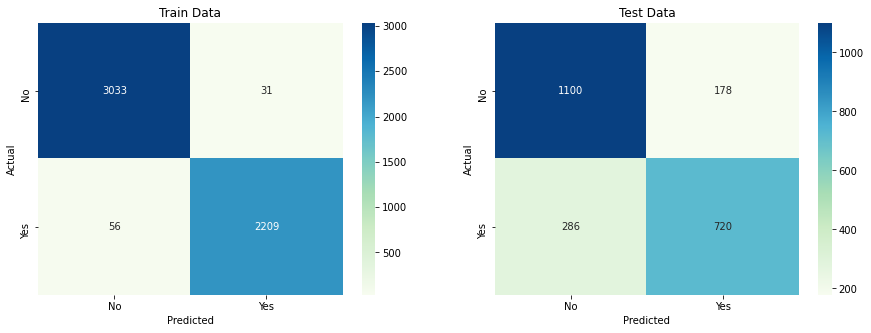

In [144]:
logistic_countvect_model.plot()

### Observations:
<ol>
    <li> The train accuracy of the model is 98% and test accuracy of the model is 79%</li>
    <li> True positive and true negative is pretty good but flase negative is also little higher unfortunately which must not be</li>
</ol>   

In [159]:
logistic_countvect_model.tableit('countvector')

In [160]:
print(final_table)

+-----------+-------------+--------------------+--------------------+
| Algorithm |    vector   |   Train accuracy   |   Test accuracy    |
+-----------+-------------+--------------------+--------------------+
|  logistic | countvector | 0.9836742353161944 | 0.7968476357267951 |
+-----------+-------------+--------------------+--------------------+


#### On TfidfVectorization

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0235s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0027s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.9s finished


--------------------
Testing  Data...
Train accuracy 0.988928504409833 Test accuracy 0.7758318739054291


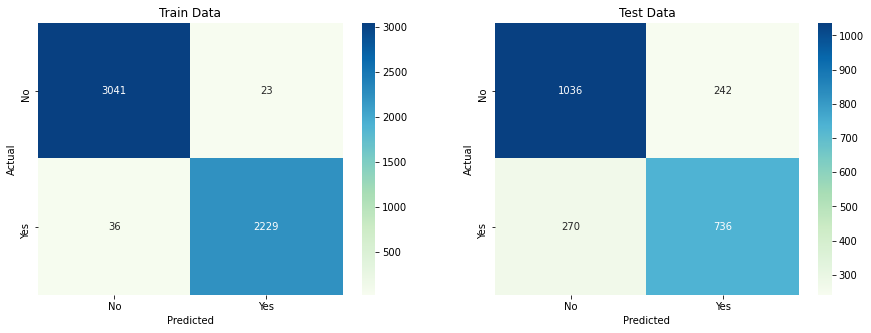

In [145]:
algo = 'logistic'
logistic_tfidf_model = ApplyModel(train = x_tfidfvect_train_all,test = x_tfidfvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
logistic_tfidf_model.assign()

logistic_tfidf_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
logistic_tfidf_model.test_data()

logistic_tfidf_model.plot()



### Observations:
<ol>
    <li> The train accuracy of the model is 98% and test accuracy of the model is 77% when compared with  logistic regression model on countvectorization this model performance is poor</li>
    <li> True positive and true negative is pretty good but flase negative and false positive is also little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix logistic regression with countvectorizer is best model till now</li>
</ol>   

In [161]:
logistic_tfidf_model.tableit('tfidf')

<h2>  Is logistic regression with tfidf performing better than logistic regression with countvectorizer?<br>NO</h2> 

#### On Countvectorization + TfidfVectorization

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0300s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.4488s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   55.8s finished


--------------------
Testing  Data...
Train accuracy 0.985363107524864 Test accuracy 0.7972854640980735


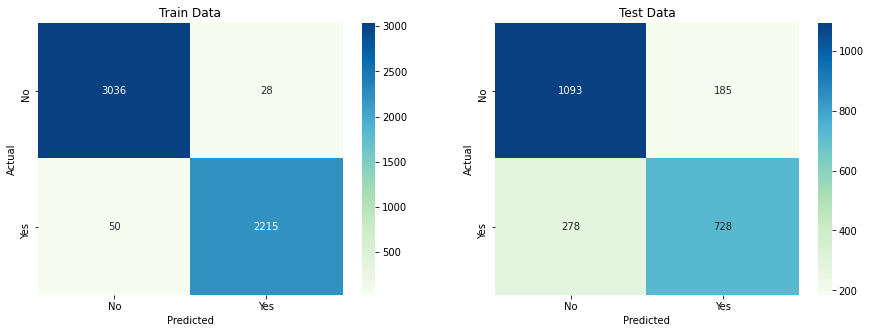

In [146]:
algo = 'logistic'
logistic_all_model = ApplyModel(train = x_train_all,test = x_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
logistic_all_model.assign()

logistic_all_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
logistic_all_model.test_data()

logistic_all_model.plot()



### Observations:
<ol>
    <li> Even though the train accuracy of the model is 98% and test accuracy of the model is 79% when compared with  previous two models this model performance is pretty good</li>
    <li> True positive and true negative is pretty good but flase negative and false positive is also little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix logistic regression with countvectorizer is best model till now</li>
</ol>   

In [163]:
logistic_all_model.tableit('countvect + tfidf')

In [164]:
print(final_table)


+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
+-----------+-------------------+--------------------+--------------------+


<h2>Is logistic regression with countvect and tfidf performing better than logistic regression with countvectorizer? <br>Both are performing almost same</h2>

### Naive Bayes

#### On CountVectorization

In [147]:
algo = 'naive'
naive_countvect_model = ApplyModel(train = x_countvect_train_all,test = x_countvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
naive_countvect_model.assign()

naive_countvect_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
naive_countvect_model.test_data()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0409s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0857s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1973s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished


--------------------
Testing  Data...
Train accuracy 0.9579658472508914 Test accuracy 0.7942206654991243


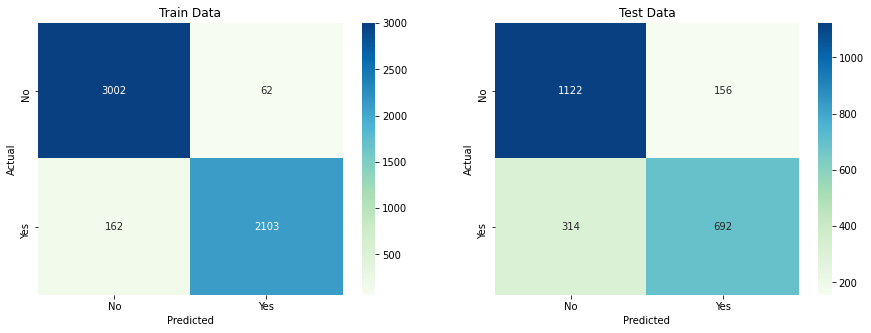

In [148]:
naive_countvect_model.plot()

### Observations:
<ol>
    <li> Train accuracy of the model is 95% and test accuracy of the model is 79% when compared with  previous models this model performance is very good</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix this model is best model till now</li>
</ol>   

In [166]:
naive_countvect_model.tableit('countvector')

In [167]:
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
+-----------+-------------------+--------------------+--------------------+


<h2> Is naive bayes performing better than logistic regression models?<br>Yes</h2>

#### On TfidfVectorization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0400s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1293s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1371s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished


--------------------
Testing  Data...
Train accuracy 0.9705385625820979 Test accuracy 0.7898423817863398


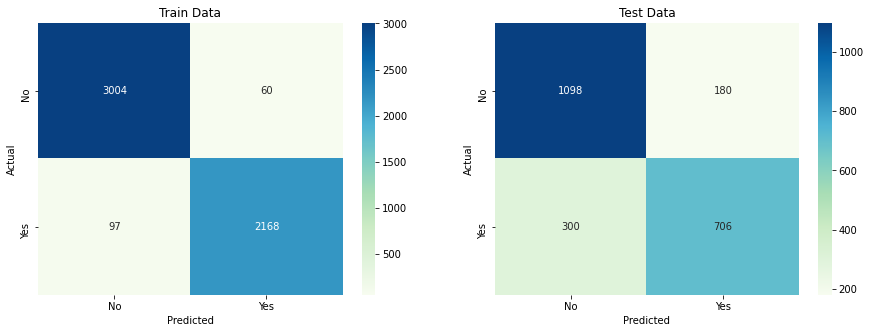

In [150]:
algo = 'naive'
naive_tfidf_model = ApplyModel(train = x_tfidfvect_train_all,test = x_tfidfvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
naive_tfidf_model.assign()

naive_tfidf_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
naive_tfidf_model.test_data()

naive_tfidf_model.plot()



### Observations:
<ol>
    <li> Train accuracy of the model is 97% and test accuracy of the model is 78% when compared with  previous  model this model performance is not so good</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix naive bayes with countvectorizer holds first place till now</li>
</ol>   

In [169]:
naive_tfidf_model.tableit('tfidf')
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
+-----------+-------------------+--------------------+--------------------+


<h2> Is naive bayes with tfidf performing better than naive bayes with countvector?<br>No</h2>

#### On Countvectorization + TfidfVectorization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0654s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1735s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1949s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished


--------------------
Testing  Data...
Train accuracy 0.9523362732219929 Test accuracy 0.7955341506129597


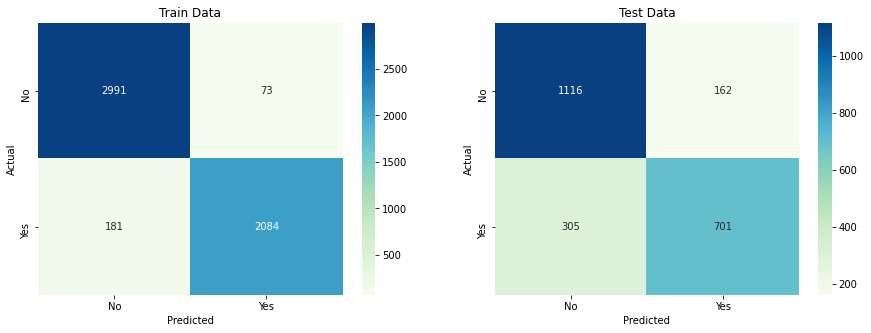

In [151]:
algo = 'naive'
naive_all_model = ApplyModel(train = x_train_all,test = x_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
naive_all_model.assign()

naive_all_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
naive_all_model.test_data()

naive_all_model.plot()



### Observations:
<ol>
    <li> Train accuracy of the model is 95% and test accuracy of the model is 79% when compared with  previous models this model performance is very good</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix this model is performing same as naive bayes model wiwth countvectorizer</li>
</ol>   

In [171]:
naive_all_model.tableit('countvect + tfidf')

In [172]:
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
|   naive   | countvect + tfidf | 0.9523362732219929 | 0.7955341506129597 |
+-----------+-------------------+--------------------+--------------------+


<h2>Is naive bayes with countvect and tfidf performing better than naive bayes with countvector?<br>No</h2>

### SGD

#### On CountVectorization

In [152]:
algo = 'sgd'
sgd_countvect_model = ApplyModel(train = x_countvect_train_all,test = x_countvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
sgd_countvect_model.assign()

sgd_countvect_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
sgd_countvect_model.test_data()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0721s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1987s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    3.0s finished


--------------------
Testing  Data...
Train accuracy 0.9547757553011822 Test accuracy 0.8029772329246935


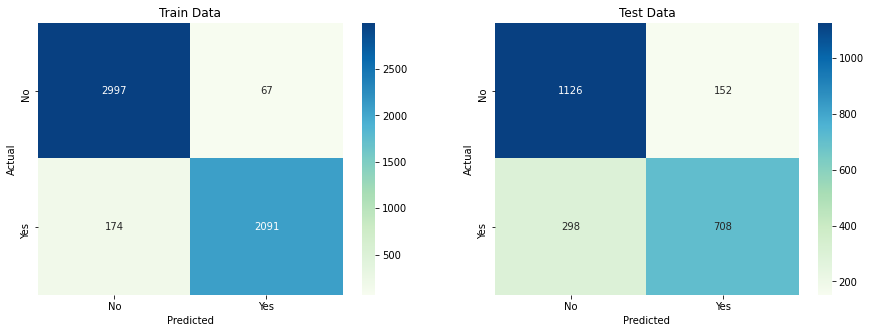

In [153]:
sgd_countvect_model.plot()

### Observations:
<ol>
    <li> Train accuracy of the model is 95% and test accuracy of the model is 80% when compared with  previous models this model performance is very good</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix this model is best model till now</li>
</ol>   

In [173]:
sgd_countvect_model.tableit('countvector')

In [174]:
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
|   naive   | countvect + tfidf | 0.9523362732219929 | 0.7955341506129597 |
|    sgd    |    countvector    | 0.9547757553011822 | 0.8029772329246935 |
+-----------+-------------------+--------------------+--------------------+


<h2>Is sgd with countvect performing better than naive bayes models?<br>Yes</h2>

#### On TfidfVectorization

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1094s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1985s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1951s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.9s finished


--------------------
Testing  Data...
Train accuracy 0.9819853631075248 Test accuracy 0.7784588441330998


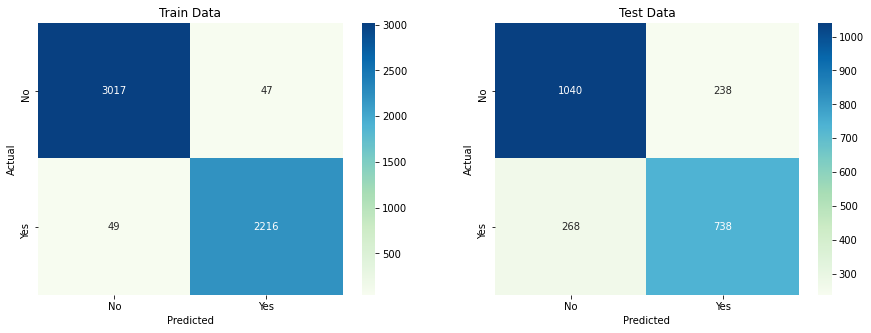

In [154]:
algo = 'sgd'
sgd_tfidf_model = ApplyModel(train = x_tfidfvect_train_all,test = x_tfidfvect_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
sgd_tfidf_model.assign()

sgd_tfidf_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
sgd_tfidf_model.test_data()

sgd_tfidf_model.plot()



### Observations:
<ol>
    <li> Train accuracy of the model is 98% and test accuracy of the model is 77% when compared with  previous models this model performance is poor</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix this model is sgd with countvectorizer is best model till now</li>
    <li>As loss is hyperparameter of the sgd lets check the best loss</li>

</ol>   

In [179]:
sgd_tfidf_model.model.loss

'hinge'

<strong>As the best loss for sgd is hinge we can say that SVM algorithm is performing well for this data  till now</strong>

In [175]:
sgd_tfidf_model.tableit('tfidf')
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
|   naive   | countvect + tfidf | 0.9523362732219929 | 0.7955341506129597 |
|    sgd    |    countvector    | 0.9547757553011822 | 0.8029772329246935 |
|    sgd    |       tfidf       | 0.9819853631075248 | 0.7784588441330998 |
+-----------+-------------------+--------------------+--------------------+


<h2>Is sgd with tfidf vector performing better than sgd with countvector?<br>No</h2>

#### On Countvector + TfidfVectorization

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1820s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1970s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.9s finished


--------------------
Testing  Data...
Train accuracy 0.959091762056671 Test accuracy 0.8021015761821366


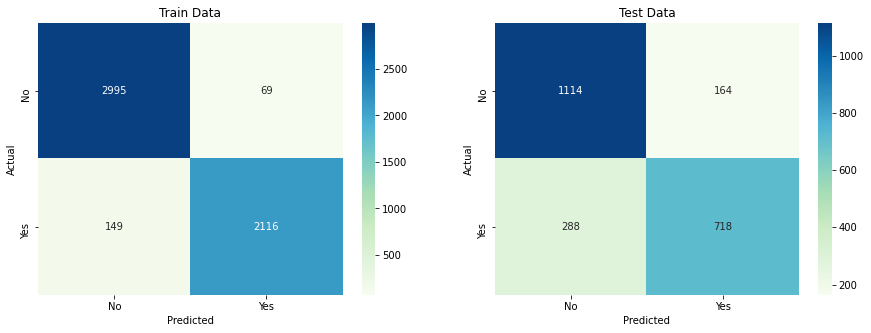

In [155]:
algo = 'sgd'
sgd_all_model = ApplyModel(train = x_train_all,test = x_test_all,ytrain=ytrain,ytest=ytest,algorithm=algo)
sgd_all_model.assign()

sgd_all_model.gridsearch(10)
time.sleep(0.2)
print('----'*5)
print('Testing  Data...')
sgd_all_model.test_data()

sgd_all_model.plot()



### Observations:
<ol>
    <li> Train accuracy of the model is 95% and test accuracy of the model is 80% when compared with  previous models this model is performing equalent to sgd with countvectorizer</li>
    <li> True positive and true negative is pretty good but flase negative is little higher unfortunately which must not be</li>
    <li>By comparing both accuracy and confusion matrix this model and sgd with countvectorizer are best models till now</li>
    <li>As loss is hyperparameter of the sgd lets check the best loss</li>
</ol>   

In [178]:
sgd_all_model.model.loss

'modified_huber'

In [177]:
sgd_all_model.tableit('countvect + tfidf')
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
|   naive   | countvect + tfidf | 0.9523362732219929 | 0.7955341506129597 |
|    sgd    |    countvector    | 0.9547757553011822 | 0.8029772329246935 |
|    sgd    |       tfidf       | 0.9819853631075248 | 0.7784588441330998 |
|    sgd    | countvect + tfidf | 0.959091762056671  | 0.8021015761821366 |
+-----------+-------------------+--------------------+--------------------+


<h2>Is sgd with countvect and tfidf vector performing better than sgd with countvector?<br>Both perform almost same</h2>

## Conclusion

<ol>
    <li>Comparing all the models with different vectors sgd was performing well</li>
    <li>Naive Bayes is also performing well and time taken my naive bayes is only 0.3s where as sgd took 4s</li>
    <li>Even though sgd is taking more time comparitively with naive bayes SGD is said to be best model because within sgd grid search is applying 3 kinds of model(losses)</li>
    <li>Logistic  regression when compared with naive and sgd, it is not performing so well and time taken by logistic regression is also more compared to naive and sgd models</li>

In [183]:
print(final_table)

+-----------+-------------------+--------------------+--------------------+
| Algorithm |       vector      |   Train accuracy   |   Test accuracy    |
+-----------+-------------------+--------------------+--------------------+
|  logistic |    countvector    | 0.9836742353161944 | 0.7968476357267951 |
|  logistic |       tfidf       | 0.988928504409833  | 0.7758318739054291 |
|  logistic | countvect + tfidf | 0.985363107524864  | 0.7972854640980735 |
|   naive   |    countvector    | 0.9579658472508914 | 0.7942206654991243 |
|   naive   |       tfidf       | 0.9705385625820979 | 0.7898423817863398 |
|   naive   | countvect + tfidf | 0.9523362732219929 | 0.7955341506129597 |
|    sgd    |    countvector    | 0.9547757553011822 | 0.8029772329246935 |
|    sgd    |       tfidf       | 0.9819853631075248 | 0.7784588441330998 |
|    sgd    | countvect + tfidf | 0.959091762056671  | 0.8021015761821366 |
+-----------+-------------------+--------------------+--------------------+
